In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-11-25 10:23:06.518121: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 10:23:06.893514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 10:23:06.893582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 10:23:06.896224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 10:23:07.041314: I tensorflow/core/platform/cpu_feature_g

In [2]:
from tools.visualization import plot_image
from defs.storage_locs import extracted_image_path, extracted_label_path
from tools.label_extract import read_extracted_labels, labels_to_df, labels_to_simple_df

KeyboardInterrupt: 

In [ ]:
raw_size = (1920, 1080)
image_size = (224, 224)
scale_factor = (image_size[0] / raw_size[0], image_size[1] / raw_size[1])
point_labels = ['1_x', '1_y', '2_x', '2_y', '3_x', '3_y', '4_x', '4_y',
                '5_x', '5_y', '6_x', '6_y', '7_x', '7_y', '8_x', '8_y',
                '9_x', '9_y', '10_x', '10_y']

In [ ]:
def load_data(dataset_names, resize_to=None):
    if resize_to is None:
        resize_to = image_size
    X = []
    y = []
    for dataset_name in dataset_names:
        labels = labels_to_simple_df(read_extracted_labels(extracted_label_path(dataset_name)))
        for index, row in labels.iterrows():
            frame = row['frame_num']
            img = cv2.imread(extracted_image_path(dataset_name, frame))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # do preprocessing here
            img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)
            X.append(img)
        y.append(labels[point_labels].reset_index(drop=True))
    X = np.array(X)
    y = pd.concat(y)
    return X, y

# X,y = load_data(['center_left_1', 'center_right_1'])

In [ ]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y, dtype=np.float32), test_size=0.2)

# MobileNetV3Small

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=image_size,
                                                    include_top=False,
                                                    weights='imagenet')

2023-11-19 22:27:08.729657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 22:27:08.782352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 22:27:08.784023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 22:27:08.789931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 22:27:08.790501: I tensorflow/compile

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
Total params: 939120 (3.58 MB)
Trainable params: 927008 (3.54 MB)
Non-trainable params: 12112 (47.31 KB)
_________________________________________________________________


In [ ]:
model.predict(X[0:1]).shape

2023-11-19 22:27:16.921886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-19 22:27:19.138044: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 6s 6s/step


2023-11-19 22:27:19.531824: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(1, 7, 7, 576)

1/1 [==============================] - 0s 42ms/step


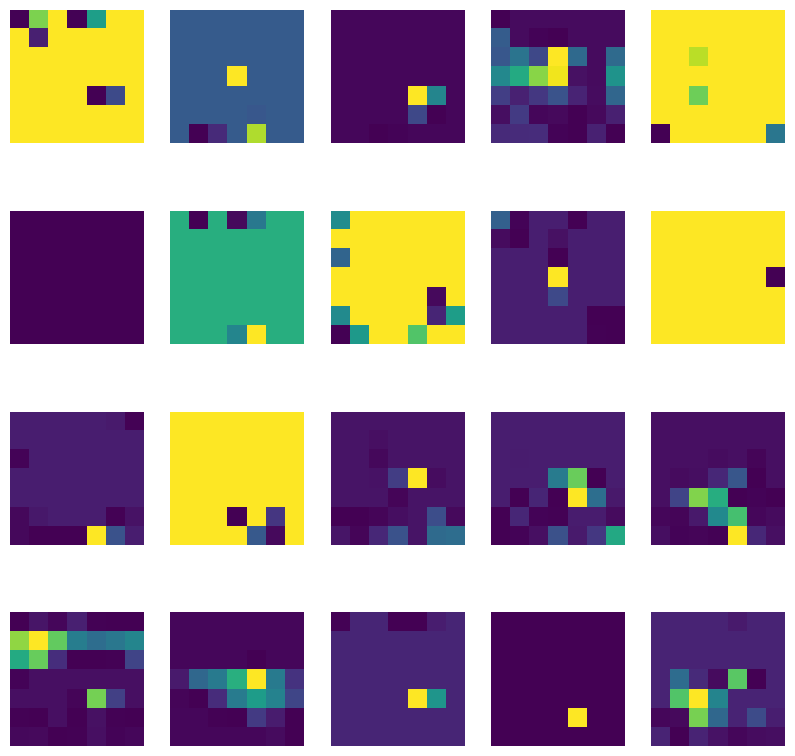

In [ ]:
# show first 20 predictions for first image in grid
prediction = model.predict(X[0:1])[0]
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)

    plt.imshow(prediction[:, :, i])
    plt.axis('off')

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20)(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dropout (Dropout)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 20)                564500    
                                                           

In [ ]:
model.predict(X[0:1])

1/1 [==============================] - 1s 849ms/step


array([[ 0.11235726, -3.6185975 , -1.726256  ,  3.3094904 , -0.888387  ,
        -1.0034229 , -3.083231  , -7.171606  ,  0.16981101, -1.221962  ,
        -2.3574967 ,  1.1656077 ,  5.0631227 ,  2.0980358 , -3.8121634 ,
        -0.88336813, -3.9211912 , -1.4991282 , -3.7543187 , -2.0325165 ]],
      dtype=float32)

In [ ]:
y_train.shape

(159, 20)

In [ ]:
# compute average euclidean distance between predictions and labels
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mae'])
              

In [ ]:
# log the loss and mae for plotting
model.fit(X_train, y_train, epochs=600, batch_size=32, validation_split=0.15)

Epoch 1/600


2023-11-19 22:27:37.879009: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x365e3430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 22:27:37.879061: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-11-19 22:27:37.884706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 22:27:38.016995: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 43s 2s/step - loss: 784308.3125 - mae: 801.5483 - val_loss: 771614.8125 - val_mae: 794.3691
Epoch 2/600
5/5 [==============================] - 0s 100ms/step - loss: 767741.8750 - mae: 791.2372 - val_loss: 745705.1875 - val_mae: 777.8643
Epoch 3/600
5/5 [==============================] - 1s 104ms/step - loss: 732646.6875 - mae: 768.7635 - val_loss: 693570.5625 - val_mae: 743.7167
Epoch 4/600
5/5 [==============================] - 1s 106ms/step - loss: 660545.1875 - mae: 720.5436 - val_loss: 588572.7500 - val_mae: 669.9943
Epoch 5/600
5/5 [==============================] - 0s 100ms/step - loss: 511797.4062 - mae: 609.1290 - val_loss: 378883.2500 - val_mae: 491.0654
Epoch 6/600
5/5 [==============================] - 1s 106ms/step - loss: 249377.4531 - mae: 366.8357 - val_loss: 133079.7188 - val_mae: 293.0006
Epoch 7/600
5/5 [==============================] - 1s 104ms/step - loss: 142953.2344 - mae: 332.2558 - val_loss: 104679.5625 - val_mae: 222.1997

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 22ms/step - loss: 588.8251 - mae: 16.2030


[588.8250732421875, 16.20299530029297]

In [ ]:
X_test[0].shape

(224, 224, 3)

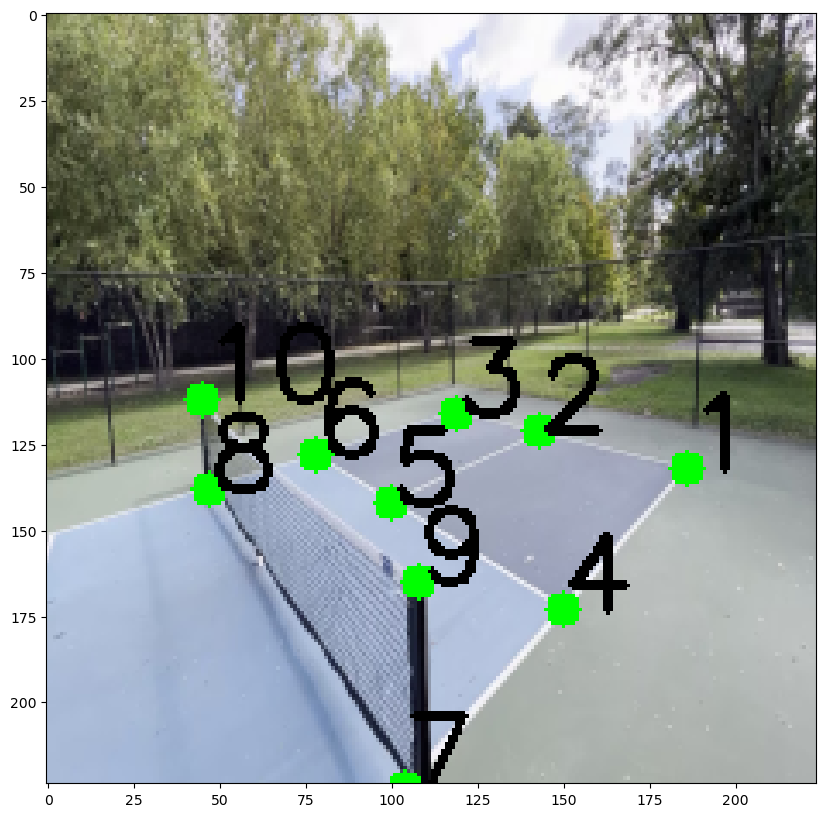

In [ ]:
from court_segment.plot_court_labels import plot_labels
from tools.visualization import plot_image
# from tools.label_extract import group_points_by_2
def group_points_by_2(points):
    # create list of points grouped by 2
    grouped_points = []
    for i in range(0, len(points), 2):
        grouped_points.append(points[i:i+2])
    return grouped_points
def scale_down_points(points, scales):
    scaled_points = [[p[0] * scales[0], p[1] * scales[1]] for p in points]
    return scaled_points

plot_image(plot_labels(X_test[1], scale_down_points(group_points_by_2(y_test[1]), scale_factor)))

1/1 [==============================] - 1s 1s/step


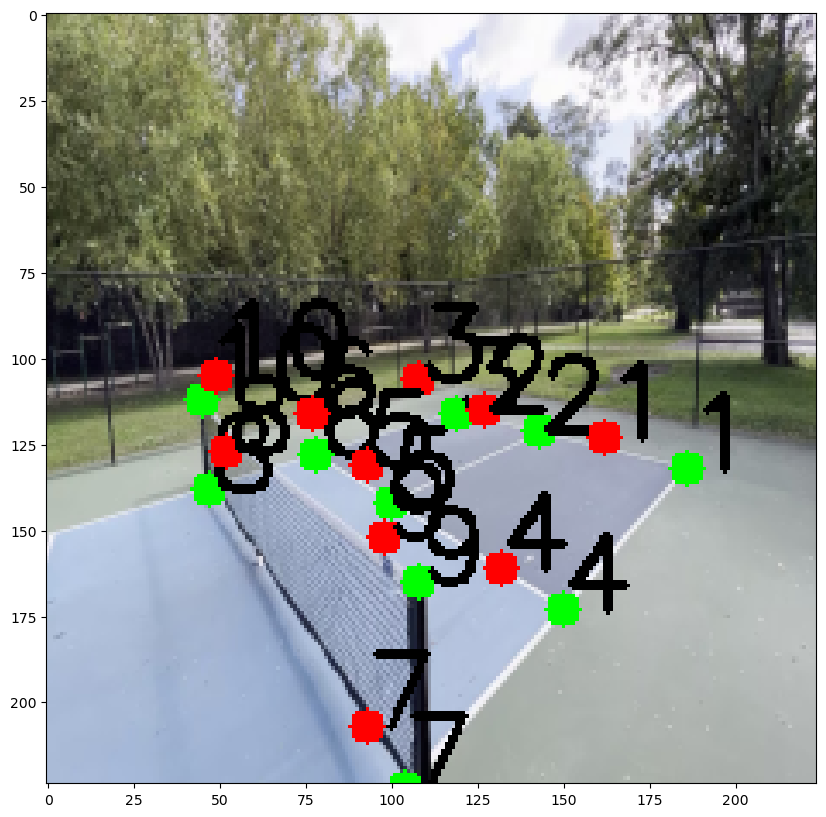

In [ ]:
predictions = model.predict(X_test[1:2])[0]
predictions = scale_down_points(group_points_by_2(predictions), scale_factor)
plot_image(plot_labels(X_test[1], predictions, color=(255, 0, 0)))

In [ ]:
group_points_by_2(y_test[0])

[array([569.97, 542.96], dtype=float32),
 array([875.81, 515.4 ], dtype=float32),
 array([1079.96,  496.44], dtype=float32),
 array([848.68, 710.64], dtype=float32),
 array([1251.6 ,  612.45], dtype=float32),
 array([1459.17,  560.03], dtype=float32),
 array([1259.87,  960.78], dtype=float32),
 array([1791.78,  615.88], dtype=float32),
 array([1203.53,  629.96], dtype=float32),
 array([1829.86,  477.05], dtype=float32)]

In [ ]:
scale_down_points(group_points_by_2(y_test[0]), scales = scale_factor)

[[118.21599392361111, 63.3453358968099],
 [181.64948097511572, 60.13000284830729],
 [223.99169560185186, 57.91800028483073],
 [176.0225169994213, 82.90800170898437],
 [259.5911060474537, 71.45250142415365],
 [302.64267578125, 65.33683675130209],
 [261.30636935763886, 112.09100341796875],
 [371.6284505208333, 71.85266723632813],
 [249.6210431134259, 73.49533589680989],
 [379.52651548032406, 55.65583190917969]]

1/1 [==============================] - 0s 129ms/step


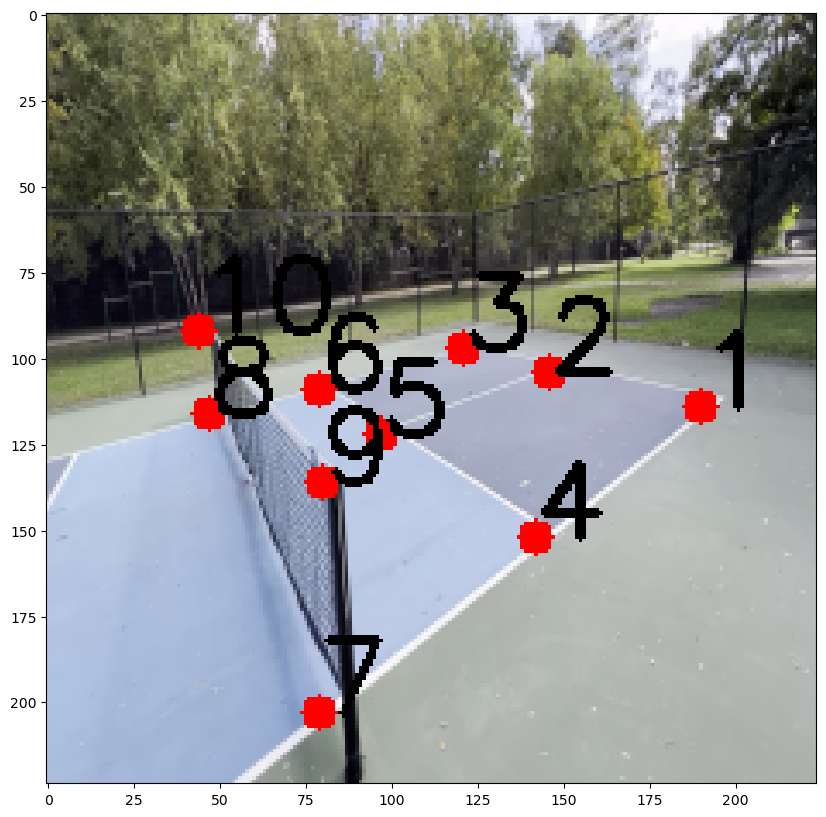

In [ ]:
predictions = model.predict(X_test[2:3])[0]
predictions = scale_down_points(group_points_by_2(predictions), scale_factor)
plot_image(plot_labels(X_test[2], predictions, color=(255, 0, 0)))

# Try with Resnet50V2

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
raw_size = (1920, 1080)
image_size = (300, 300)
scale_factor = (image_size[0] / raw_size[0], image_size[1] / raw_size[1])
point_labels = ['1_x', '1_y', '2_x', '2_y', '3_x', '3_y', '4_x', '4_y',
                '5_x', '5_y', '6_x', '6_y', '7_x', '7_y', '8_x', '8_y',
                '9_x', '9_y', '10_x', '10_y']

In [ ]:
X,y = load_data(['center_left_1', 'center_right_1'], resize_to=image_size)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y, dtype=np.float32), test_size=0.2)

In [ ]:
bm = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3),
)


2023-11-20 16:50:50.648473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 16:50:50.702691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 16:50:50.703405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 16:50:50.709188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 16:50:50.709998: I tensorflow/compile

In [ ]:
# save weights
# bm.save_weights('resnet_weights.h5')

# load weights
bm.load_weights('resnet_weights.h5')

NameError: name 'bm' is not defined

In [ ]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = bm(inputs, training=False)
x.trainable = False
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20)(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 10, 10, 2048)      23564800  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dropout_1 (Dropout)         (None, 204800)            0         
                                                                 
 dense_1 (Dense)             (None, 20)                4096020   
                                                                 
Total params: 27660820 (105.52 MB)
Trainable params: 27615380 (105.34 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, epochs=600, batch_size=5, validation_split=0.15)

Epoch 1/600
27/27 [==============================] - 27s 256ms/step - loss: 106948.3906 - mae: 213.0715 - val_loss: 11272.4033 - val_mae: 90.6564
Epoch 2/600
27/27 [==============================] - 4s 145ms/step - loss: 7473.2793 - mae: 65.3655 - val_loss: 2815.8611 - val_mae: 38.5486
Epoch 3/600
27/27 [==============================] - 4s 148ms/step - loss: 2316.6196 - mae: 37.0024 - val_loss: 2121.1252 - val_mae: 35.0613
Epoch 4/600
27/27 [==============================] - 4s 147ms/step - loss: 1519.4381 - mae: 30.7102 - val_loss: 780.1673 - val_mae: 21.6557
Epoch 5/600
27/27 [==============================] - 4s 146ms/step - loss: 1025.4202 - mae: 25.4578 - val_loss: 491.3740 - val_mae: 17.4992
Epoch 6/600
27/27 [==============================] - 4s 146ms/step - loss: 950.8609 - mae: 24.4209 - val_loss: 440.0707 - val_mae: 16.5629
Epoch 7/600
27/27 [==============================] - 4s 146ms/step - loss: 967.1667 - mae: 24.5622 - val_loss: 386.5943 - val_mae: 15.3744
Epoch 8/600
27

KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

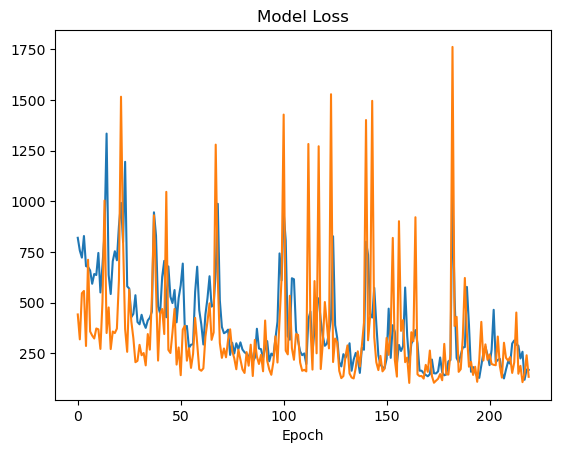

In [ ]:
# plot the history of the loss
plt.plot(model.history.history['loss'][10:])
plt.plot(model.history.history['val_loss'][10:])
plt.title('Model Loss')
plt.xlabel('Epoch')


In [ ]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)